In [26]:
import os
import pandas as pd

from typing import Tuple

from spacy import displacy
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
DATASET_FOLDER = 'feedback-prize-2021'

def load_data_csv() -> pd.DataFrame:
    return pd.read_csv(
        os.path.join(DATASET_FOLDER, 'train.csv'), 
        dtype={'discourse_id': 'int64', 'discourse_start': int, 'discourse_end': int})

def load_file(file_id: str, folder: str = 'train') -> str:
    path = os.path.join(DATASET_FOLDER, folder, file_id + '.txt')
    with open(path, 'r') as f:
        text = f.read()
    return text

def load_texts(folder: str = 'train') -> pd.Series:
    data_path = os.path.join(DATASET_FOLDER, folder)

    def read(filename):
        with open(os.path.join(data_path, filename), 'r') as f:
            text = f.read()
        return text

    return pd.Series({fname.replace('.txt', ''): read(fname) for fname in tqdm(os.listdir(data_path))})     

def load_dataset() -> Tuple[pd.Series, pd.DataFrame]:
    return load_texts(), load_data_csv()

In [13]:
# Credits for this part of visualisation _> https://www.kaggle.com/thedrcat

DISCOURSE_TYPES_COLORS = {
    'Lead': '#8000ff',
    'Position': '#2b7ff6',
    'Evidence': '#2adddd',
    'Claim': '#80ffb4',
    'Concluding Statement': 'd4dd80',
    'Counterclaim': '#ff8042',
    'Rebuttal': '#ff0000'
}

def highlight_segments(id_example, texts, data):         
    ents = []
    for _, row in data[data['id'] == id_example].iterrows():
        ents.append({
            'start': int(row['discourse_start']), 
            'end': int(row['discourse_end']), 
            'label': row['discourse_type']
            })
    doc2 = {'text': texts[id_example], 'ents': ents, 'title': id_example}
    options = {'ents': data.discourse_type.unique().tolist(), 'colors': DISCOURSE_TYPES_COLORS}
    displacy.render(doc2, style='ent', options=options, manual=True, jupyter=True)

In [14]:
train_texts, train_data = load_dataset()

100%|██████████| 15594/15594 [00:01<00:00, 10634.38it/s]


In [15]:
test_texts = load_texts('test')

100%|██████████| 5/5 [00:00<?, ?it/s]


In [16]:
train_data.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


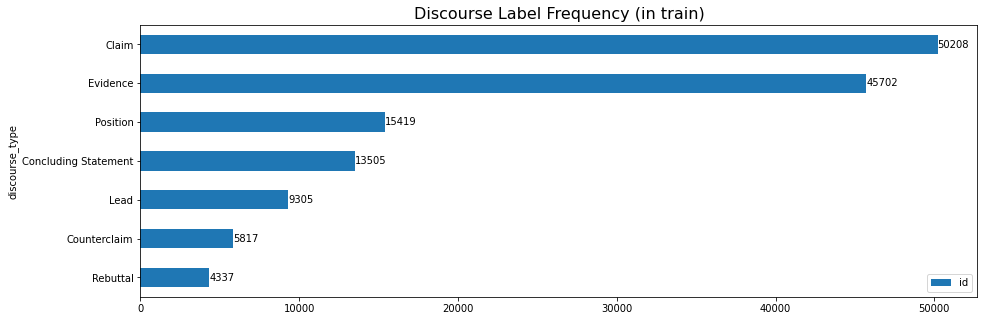

In [32]:
# Most annotation used:

ax = (
    train_data.groupby(by='discourse_type')[['id']]
    .count()
    .sort_values('id')
    .plot(kind="barh", figsize=(15, 5))
)
ax.set_title("Discourse Label Frequency (in train)", fontsize=16)
ax.bar_label(ax.containers[0], label_type="edge")
plt.show()

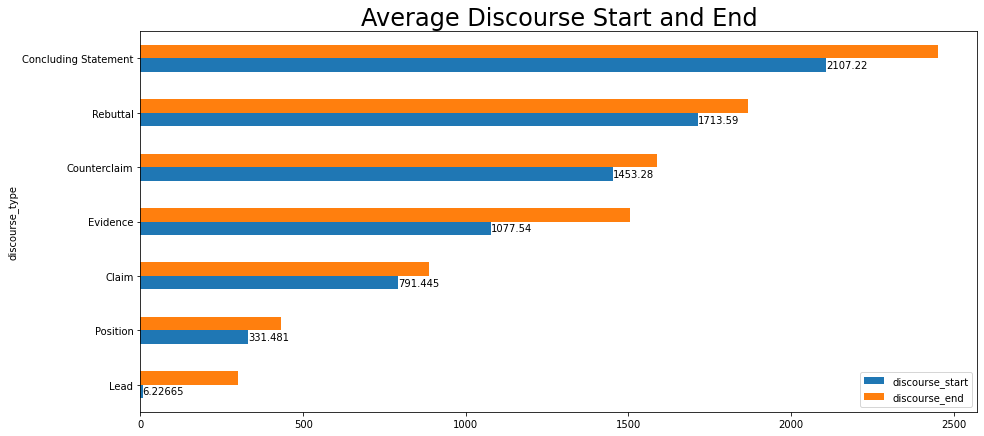

In [34]:
ax = (
    train_data.groupby("discourse_type")[["discourse_start", "discourse_end"]]
    .mean()
    .sort_values("discourse_start")
    .plot(kind="barh", figsize=(15, 7))
)
ax.set_title("Average Discourse Start and End", fontsize=24)
ax.bar_label(ax.containers[0], label_type="edge")
plt.show()

In [23]:
ids_with_parts_no_label = []

for group_id, group in train_data.groupby(by='id'):
    init = -1
    for _, row in group.iterrows():
        g_init = row.discourse_start
        if g_init > init + 1:
            part = train_texts[group_id][init: g_init]
            if len(part) > 500: # keep only that ones with large parts without label
                ids_with_parts_no_label.append(group_id)
                break
        init = row.discourse_end
    if len(ids_with_parts_no_label) > 5: # only the firsts
        break
    

In [24]:
# examples = data['id'].sample(n=1, random_state=42).values.tolist()
examples = ids_with_parts_no_label
for ex in examples:
    highlight_segments(ex, train_texts, train_data)
    print('\n')